# Results Evaluation

In [1]:
%run ../scripts/load_df_for_analysis.py

In [2]:
%run ../scripts/data_visualisations.py

In [3]:
%run ../scripts/df_calculations.py

In [4]:
%run ../scripts/significance_tests.py

## Overall model results

### Comparison of best GPT and best Llama Model (from tested models on this data): <br>GPT 4.1 vs. Llama 3.1:70b

In [5]:
chunking = "1024_20"
only_text = True
model = "gpt-4.1-2025-04-14"
df_gpt = load_df_for_analysis(chunking, only_text, model)
results_gpt = eval_predictions(df_gpt, include_relabelled_partially=True)
results_gpt_no_partially = eval_predictions(df_gpt, include_relabelled_partially=False)

In [6]:
chunking = "256_20"
only_text = True
model = "llama3.1.70b"
df_llama = load_df_for_analysis(chunking, only_text, model)
results_llama = eval_predictions(df_llama, include_relabelled_partially=True)
results_llama_no_partially = eval_predictions(df_llama, include_relabelled_partially=False)

In [7]:
model_results = {
    "GPT-4.1 (1024 token chunks)": results_gpt,
    "Llama 3.1:70b (256 token chunks)": results_llama,
}

model_results_no_partially = {
    "GPT-4.1 (1024 token chunks)": results_gpt_no_partially,
    "Llama 3.1:70b (256 token chunks)": results_llama_no_partially
}

display_model_results_table(model_results)
display_model_results_table(model_results_no_partially)

,Balanced Accuracy,Precision (Unsubstantiated),Recall (Unsubstantiated),F1 Score (Unsubstantiated),Precision (Substantiated),Recall (Substantiated),F1 Score (Substantiated)
Model,,,,,,,
GPT-4.1 (1024 token chunks),0.856,0.877,0.809,0.842,0.844,0.902,0.872
Llama 3.1:70b (256 token chunks),0.810,0.748,0.878,0.808,0.875,0.742,0.803


,Balanced Accuracy,Precision (Unsubstantiated),Recall (Unsubstantiated),F1 Score (Unsubstantiated),Precision (Substantiated),Recall (Substantiated),F1 Score (Substantiated)
Model,,,,,,,
GPT-4.1 (1024 token chunks),0.873,0.890,0.832,0.860,0.865,0.913,0.888
Llama 3.1:70b (256 token chunks),0.836,0.756,0.925,0.832,0.922,0.746,0.825


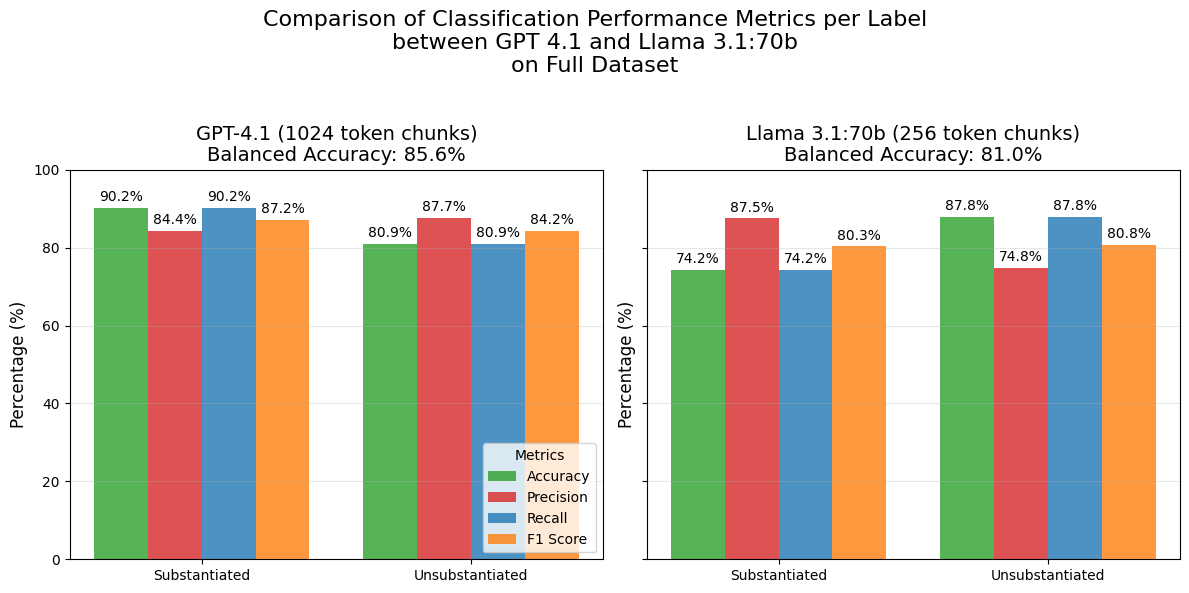

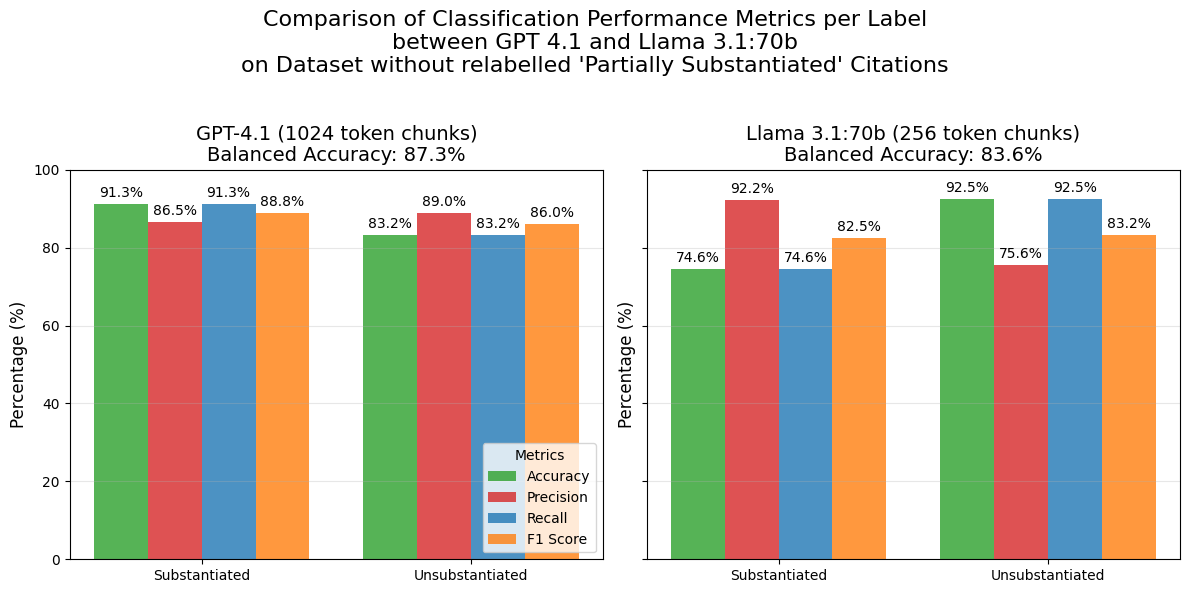

In [8]:
show_metrics_per_label(model_results, "Comparison of Classification Performance Metrics per Label\nbetween GPT 4.1 and Llama 3.1:70b\non Full Dataset")

show_metrics_per_label(model_results_no_partially, "Comparison of Classification Performance Metrics per Label\nbetween GPT 4.1 and Llama 3.1:70b\non Dataset without relabelled 'Partially Substantiated' Citations")

## Comparison: Evaluation per Annotation Attribute

In [9]:
def attribute_predictions_per_model(model_dfs, attribute, relabelled_partially=False, group_numbers_from=False):
    results = {}
    for model_name, df in model_dfs.items():
        results[model_name] = eval_predictions_per_attribute_value(df, attribute, include_relabelled_partially=True, group_numbers_from=group_numbers_from)
        if relabelled_partially:
            results[model_name + " (exclude relabelled partially)"] = eval_predictions_per_attribute_value(df, attribute, include_relabelled_partially=False, group_numbers_from=group_numbers_from)
    return results

In [10]:
def fisher_exact_for_attribute(df, attribute, group_numbers_from=False):
    results = {}
    attribute_groups = get_attribute_value_groups(df, attribute, group_numbers_from)
    for group_name, attribute_values_list in attribute_groups:
        results[group_name] = calc_fisher_exact_total_sub_unsub(
            eval_attribute_subset_vs_rest(df, attribute, attribute_values_list)
        )
    display_fishers_exact_test_results(results)

In [11]:
def chi_squared_for_attribute(df, attribute, group_numbers_from=False):
    attribute_groups = get_attribute_value_groups(df, attribute, group_numbers_from)
    evals = eval_per_attribute_value(df, attribute, attribute_groups)
    results = calc_chi_squared_total_sub_unsub(evals, [group_name for group_name, _ in attribute_groups])
    display_chi_squared_test_results(results)

In [12]:
def permutation_test_for_attribute(df, attribute, group_numbers_from, n_permutations):
    results = calc_permutation_test_total_sub_unsub(df, attribute, group_numbers_from, n_permutations)
    display_permutation_test_results(results)

In [13]:
def significance_tests_per_model_for_attribute(model_dfs, attribute, group_numbers_from=False, n_permutations=1000):
    for model_name, df in model_dfs.items():
        print(f"---- ## Significance tests results for {model_name} on attribute '{attribute}': ## ----")
        # Fishers exact test
        print(f"Fisher's exact test results (per attributevalue when compared to rest):")
        fisher_exact_for_attribute(df, attribute, group_numbers_from)

        # Chi-Squared test
        print(f"Chi-squared test results (comparison over all attribute values):")
        chi_squared_for_attribute(df, attribute, group_numbers_from)

        # Permutation test
        print(f"Permutation test results (comparison per metric over {n_permutations} permutations):")
        permutation_test_for_attribute(df, attribute, group_numbers_from, n_permutations)

        print("\n\n")

In [14]:
model_dfs = {
    "GPT-4.1": df_gpt,
    "Llama 3.1:70b": df_llama
}

### Reference Only

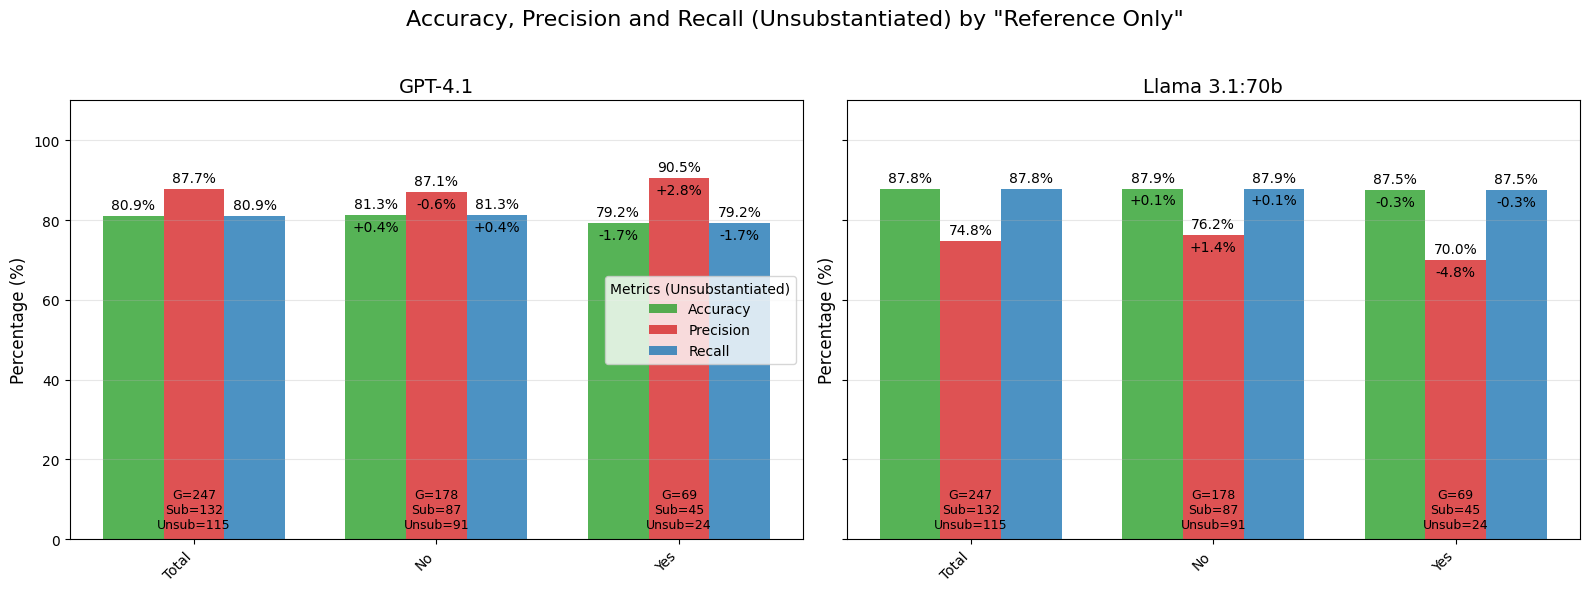

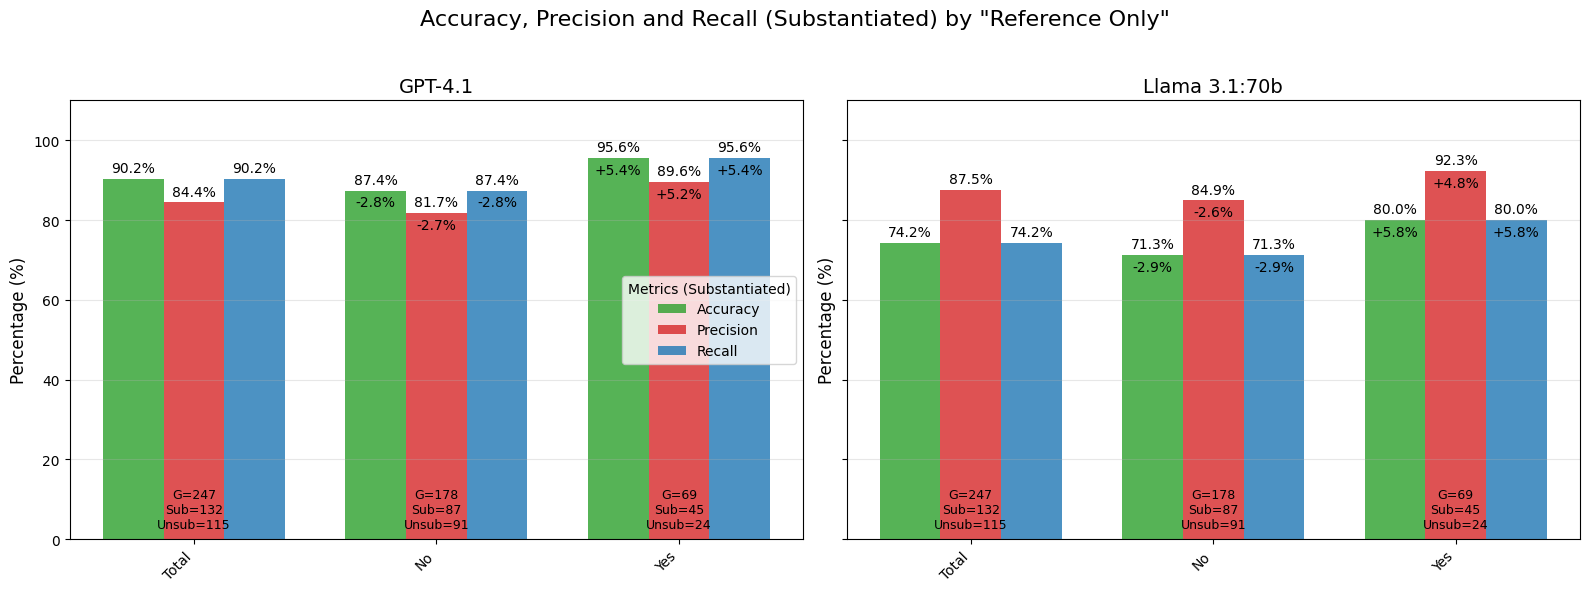

In [15]:
attribute = "Reference Only"
results = attribute_predictions_per_model(model_dfs, attribute)
show_metrics_by_attribute_values(results, attribute, "Unsubstantiated")
show_metrics_by_attribute_values(results, attribute, "Substantiated")

In [16]:
significance_tests_per_model_for_attribute(model_dfs, attribute)

---- ## Significance tests results for GPT-4.1 on attribute 'Reference Only': ## ----
Fisher's exact test results (per attributevalue when compared to rest):


,Total Odds Ratio,Total P-value,Unsubstantiated Odds Ratio,Unsubstantiated P-value,Substantiated Odds Ratio,Substantiated P-value
Attribute Value,,,,,,
Yes,1.6533,0.3129,0.8730,0.7769,3.1118,0.2172
No,0.6048,0.3129,1.1455,0.7769,0.3214,0.2172


Chi-squared test results (comparison over all attribute values):


,Total Chi2,Total P-value,Unsubstantiated Chi2,Unsubstantiated P-value,Substantiated Chi2,Substantiated P-value
0,1.3136,0.2517,0.0165,0.8978,0.6967,0.4039


Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,0.000027,0.3040,N/A,N/A,N/A,N/A
Accuracy,0.000507,0.1760,-0.001167,0.6430,0.000108,0.2720
Precision,N/A,N/A,-0.001110,0.7990,0.001438,0.1370
Recall,N/A,N/A,-0.001167,0.6430,0.000108,0.2720
F1 Score,N/A,N/A,-0.000574,0.6100,0.001114,0.0790





---- ## Significance tests results for Llama 3.1:70b on attribute 'Reference Only': ## ----
Fisher's exact test results (per attributevalue when compared to rest):


,Total Odds Ratio,Total P-value,Unsubstantiated Odds Ratio,Unsubstantiated P-value,Substantiated Odds Ratio,Substantiated P-value
Attribute Value,,,,,,
Yes,1.2042,0.7210,0.9625,1.0000,1.6129,0.3025
No,0.8304,0.7210,1.0390,1.0000,0.6200,0.3025


Chi-squared test results (comparison over all attribute values):


,Total Chi2,Total P-value,Unsubstantiated Chi2,Unsubstantiated P-value,Substantiated Chi2,Substantiated P-value
0,0.0000,1.0000,0.0000,1.0000,0.3761,0.5397


Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,-0.000491,0.6500,N/A,N/A,N/A,N/A
Accuracy,-0.000698,0.9770,-0.000691,0.6950,-0.000667,0.4180
Precision,N/A,N/A,0.000137,0.2830,-0.000566,0.5790
Recall,N/A,N/A,-0.000691,0.6950,-0.000667,0.4180
F1 Score,N/A,N/A,0.000081,0.2780,-0.000120,0.3460


### Claim Contains Number or Formula

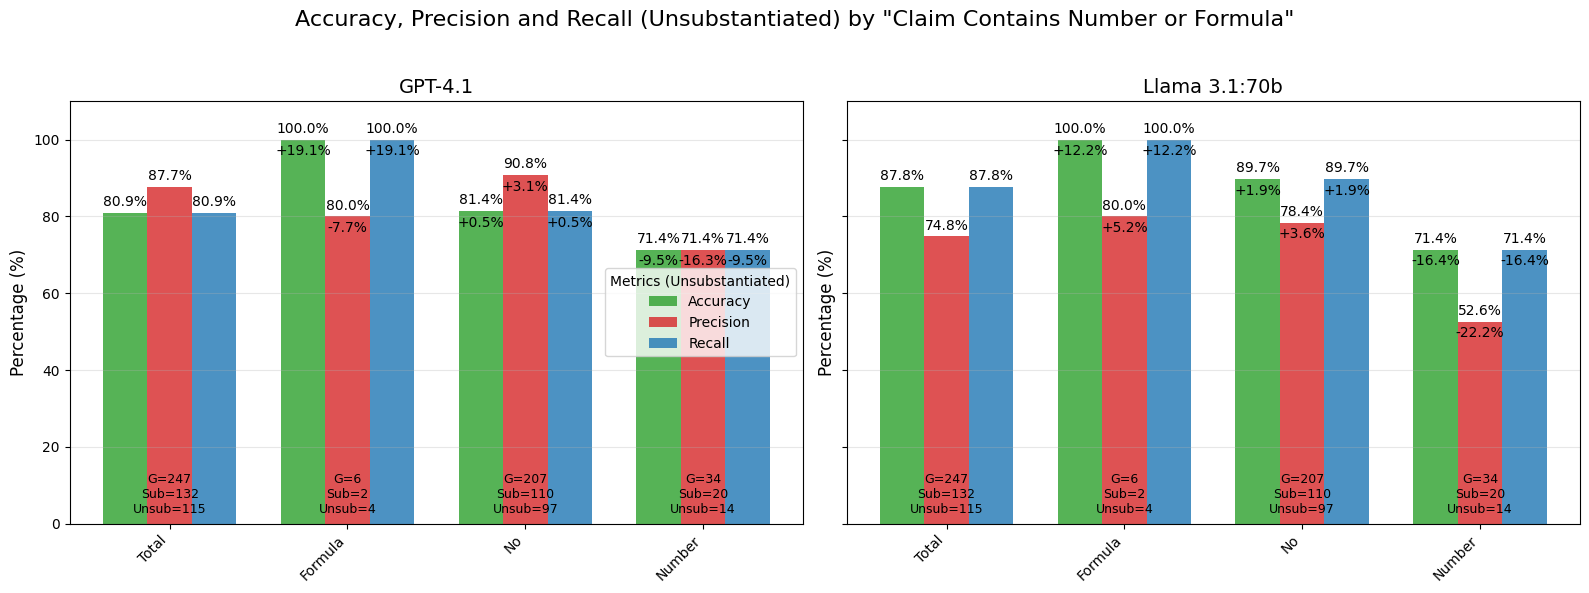

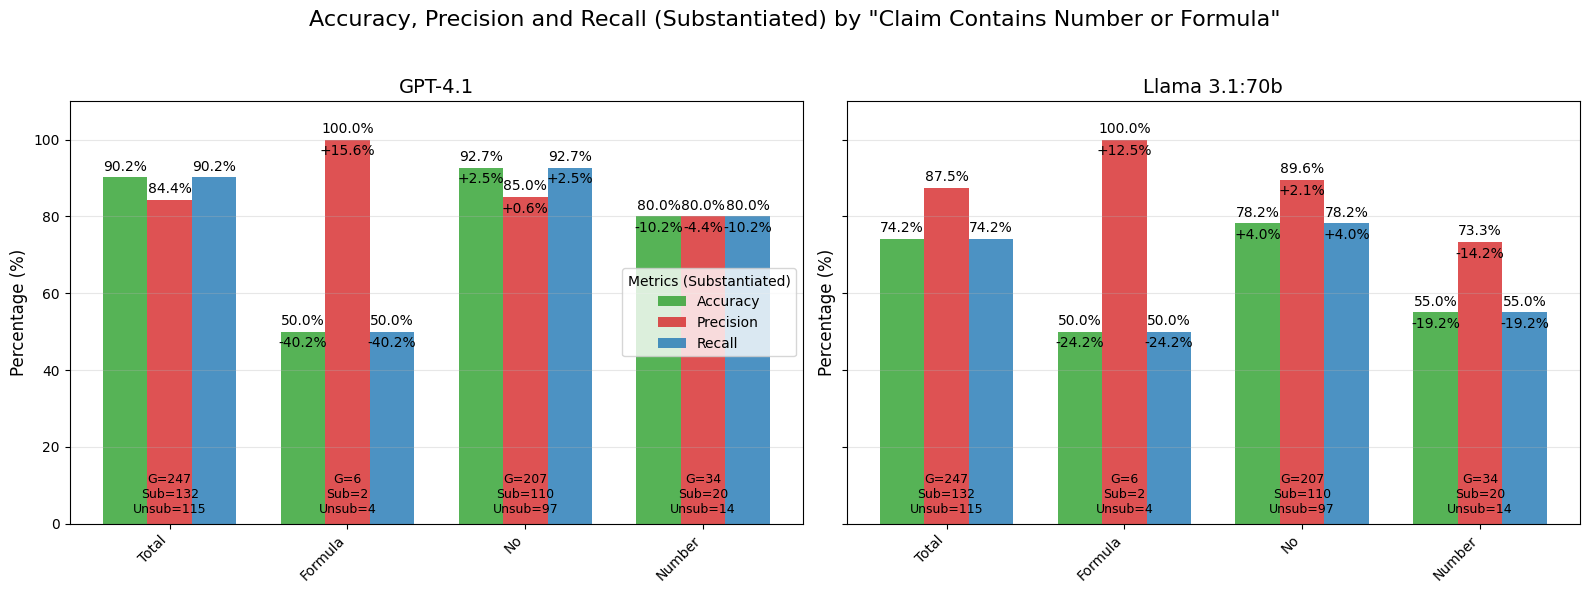

In [17]:
attribute = "Claim Contains Number or Formula"
results = attribute_predictions_per_model(model_dfs, attribute)
show_metrics_by_attribute_values(results, attribute, "Unsubstantiated")
show_metrics_by_attribute_values(results, attribute, "Substantiated")

In [18]:
significance_tests_per_model_for_attribute(model_dfs, attribute)

---- ## Significance tests results for GPT-4.1 on attribute 'Claim Contains Number or Formula': ## ----
Fisher's exact test results (per attributevalue when compared to rest):


,Total Odds Ratio,Total P-value,Unsubstantiated Odds Ratio,Unsubstantiated P-value,Substantiated Odds Ratio,Substantiated P-value
Attribute Value,,,,,,
No,2.0211,0.1337,1.2540,0.7467,3.7500,0.0421
Number,0.4718,0.1107,0.5422,0.4659,0.3495,0.1105
Formula,0.8213,1.0000,N/A,N/A,0.1017,0.1879


Chi-squared test results (comparison over all attribute values):


,Total Chi2,Total P-value,Unsubstantiated Chi2,Unsubstantiated P-value,Substantiated Chi2,Substantiated P-value
0,0.8352,0.6586,0.8448,0.6555,6.2995,0.0429


Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,-0.005258,0.7290,N/A,N/A,N/A,N/A
Accuracy,-0.004641,0.8810,-0.015912,0.5610,0.025324,0.0580
Precision,N/A,N/A,-0.016795,0.4140,-0.007636,0.7950
Recall,N/A,N/A,-0.015912,0.5610,0.025324,0.0580
F1 Score,N/A,N/A,-0.016978,0.7920,0.002200,0.1360





---- ## Significance tests results for Llama 3.1:70b on attribute 'Claim Contains Number or Formula': ## ----
Fisher's exact test results (per attributevalue when compared to rest):


,Total Odds Ratio,Total P-value,Unsubstantiated Odds Ratio,Unsubstantiated P-value,Substantiated Odds Ratio,Substantiated P-value
Attribute Value,,,,,,
No,2.7398,0.0145,2.4857,0.2299,2.9861,0.0312
Number,0.3176,0.0051,0.2747,0.0677,0.3512,0.0496
Formula,1.2113,1.0000,N/A,N/A,0.3402,0.4503


Chi-squared test results (comparison over all attribute values):


,Total Chi2,Total P-value,Unsubstantiated Chi2,Unsubstantiated P-value,Substantiated Chi2,Substantiated P-value
0,4.4885,0.1060,0.3670,0.8324,4.8511,0.0884


Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,-0.006219,0.6140,N/A,N/A,N/A,N/A
Accuracy,-0.001936,0.5900,-0.013680,0.7100,-0.005488,0.4030
Precision,N/A,N/A,-0.007338,0.5610,-0.014495,0.7530
Recall,N/A,N/A,-0.013680,0.7100,-0.005488,0.4030
F1 Score,N/A,N/A,-0.007482,0.3430,-0.009219,0.4860


### Amount Citations in Sentence

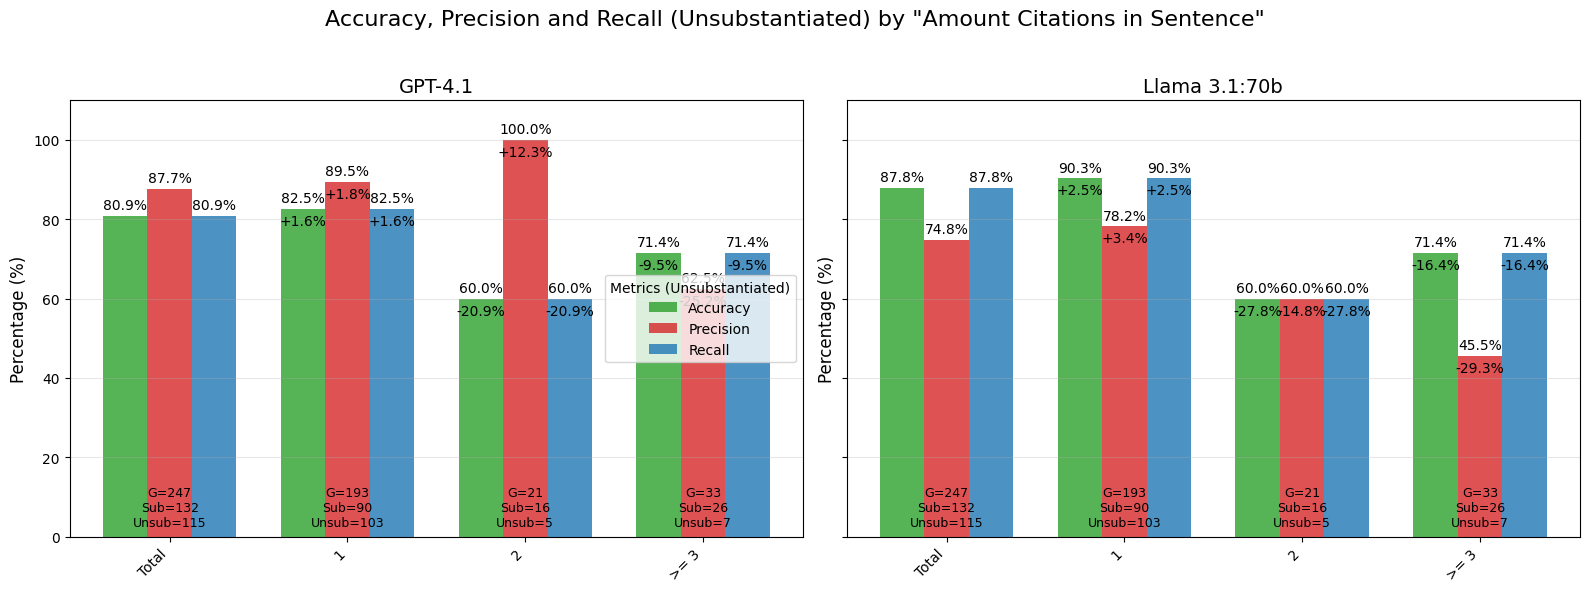

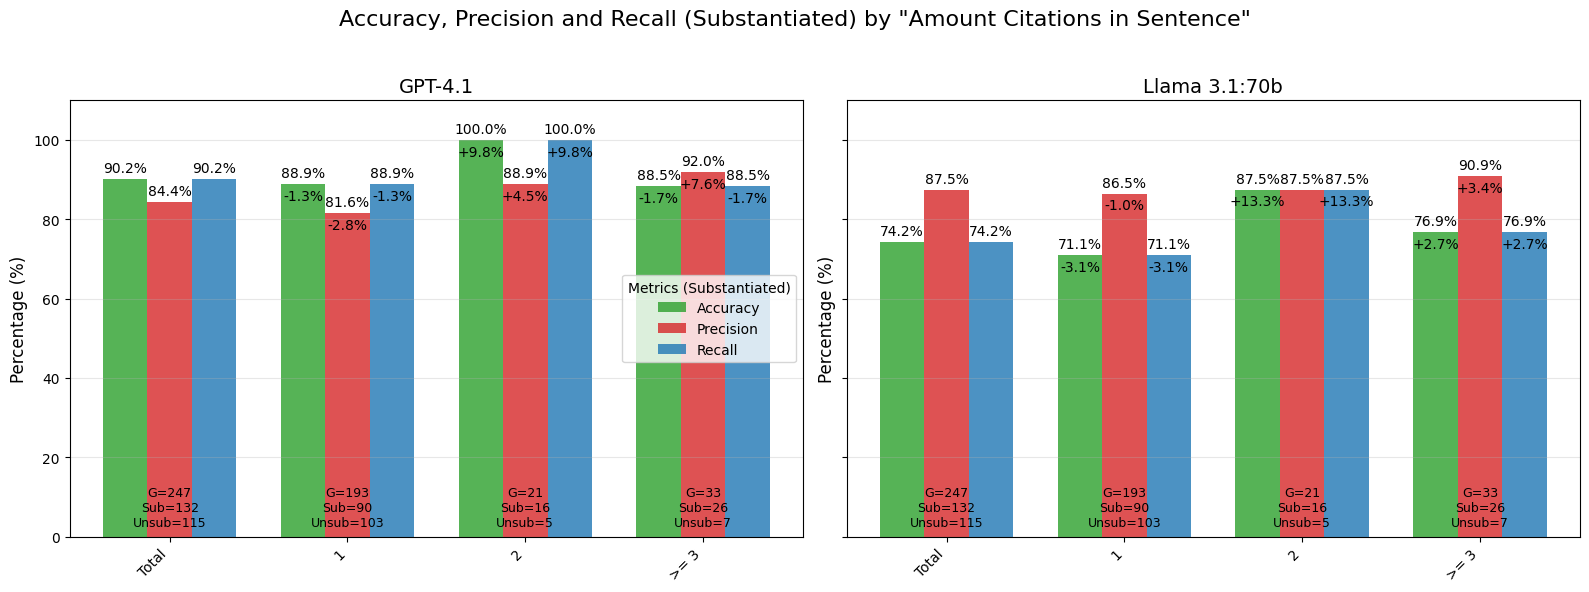

In [19]:
attribute = "Amount Citations in Sentence"
results = attribute_predictions_per_model(model_dfs, attribute, group_numbers_from=3)
show_metrics_by_attribute_values(results, attribute, "Unsubstantiated")
show_metrics_by_attribute_values(results, attribute, "Substantiated")

In [20]:
significance_tests_per_model_for_attribute(model_dfs, attribute, group_numbers_from=3)

---- ## Significance tests results for GPT-4.1 on attribute 'Amount Citations in Sentence': ## ----
Fisher's exact test results (per attributevalue when compared to rest):


,Total Odds Ratio,Total P-value,Unsubstantiated Odds Ratio,Unsubstantiated P-value,Substantiated Odds Ratio,Substantiated P-value
Attribute Value,,,,,,
1,0.8777,1.0000,2.3611,0.2396,0.6154,0.5499
2,1.6244,0.7472,0.3333,0.2428,N/A,N/A
>= 3,0.9130,0.7929,0.5682,0.6173,0.7986,0.7195


Chi-squared test results (comparison over all attribute values):


,Total Chi2,Total P-value,Unsubstantiated Chi2,Unsubstantiated P-value,Substantiated Chi2,Substantiated P-value
0,1.1424,0.5648,1.3957,0.4976,1.7417,0.4186


Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,-0.000241,0.3880,N/A,N/A,N/A,N/A
Accuracy,-0.001048,0.6290,0.012025,0.0690,-0.000560,0.3860
Precision,N/A,N/A,0.029480,0.0050,0.001579,0.2170
Recall,N/A,N/A,0.012025,0.0690,-0.000560,0.3860
F1 Score,N/A,N/A,-0.000137,0.3170,-0.000028,0.3140





---- ## Significance tests results for Llama 3.1:70b on attribute 'Amount Citations in Sentence': ## ----
Fisher's exact test results (per attributevalue when compared to rest):


,Total Odds Ratio,Total P-value,Unsubstantiated Odds Ratio,Unsubstantiated P-value,Substantiated Odds Ratio,Substantiated P-value
Attribute Value,,,,,,
1,1.2460,0.5628,4.6500,0.0391,0.5792,0.2875
2,1.0275,1.0000,0.1837,0.1115,2.6667,0.2392
>= 3,0.7184,0.4796,0.3125,0.2025,1.1966,0.8074


Chi-squared test results (comparison over all attribute values):


,Total Chi2,Total P-value,Unsubstantiated Chi2,Unsubstantiated P-value,Substantiated Chi2,Substantiated P-value
0,0.1944,0.9074,3.2555,0.1964,1.5874,0.4522


Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,-0.000442,0.4090,N/A,N/A,N/A,N/A
Accuracy,-0.002725,0.8980,0.017242,0.0170,-0.003653,0.5800
Precision,N/A,N/A,0.021290,0.0170,-0.001647,0.6120
Recall,N/A,N/A,0.017242,0.0170,-0.003653,0.5800
F1 Score,N/A,N/A,0.014471,0.0120,-0.002256,0.6040


### Amount References for Claim

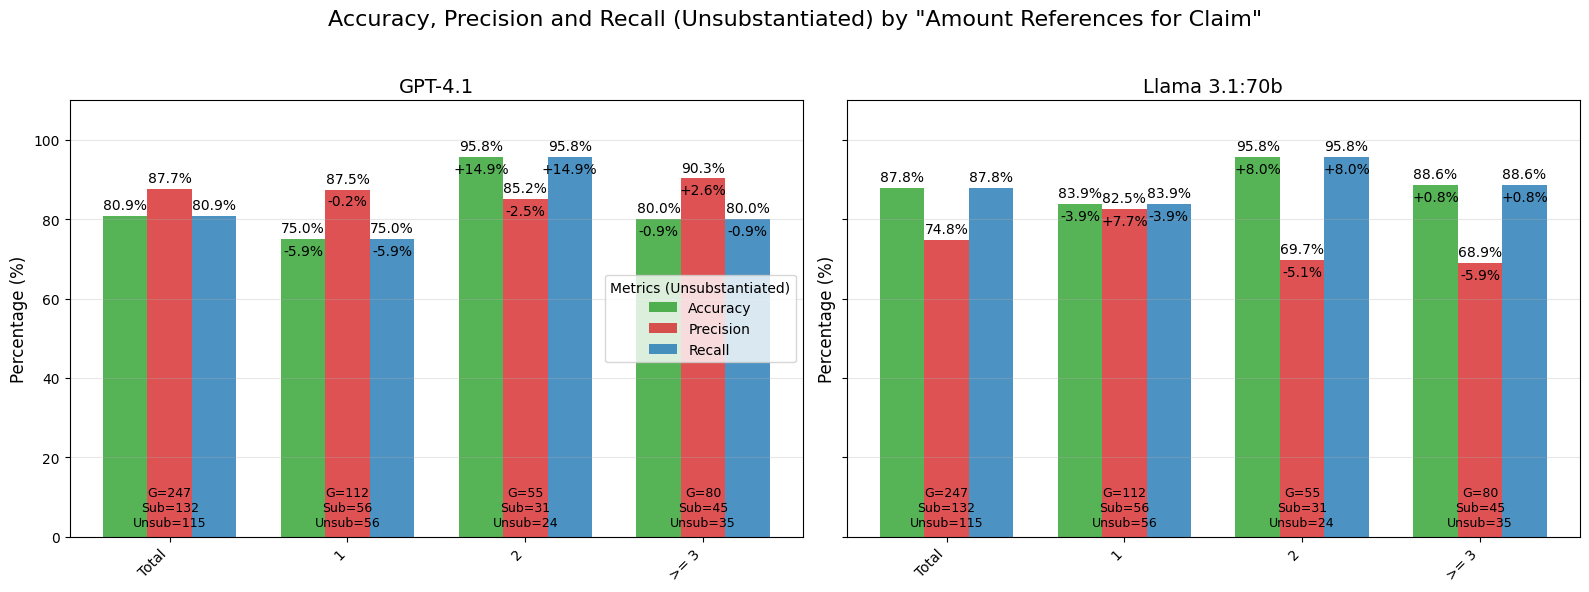

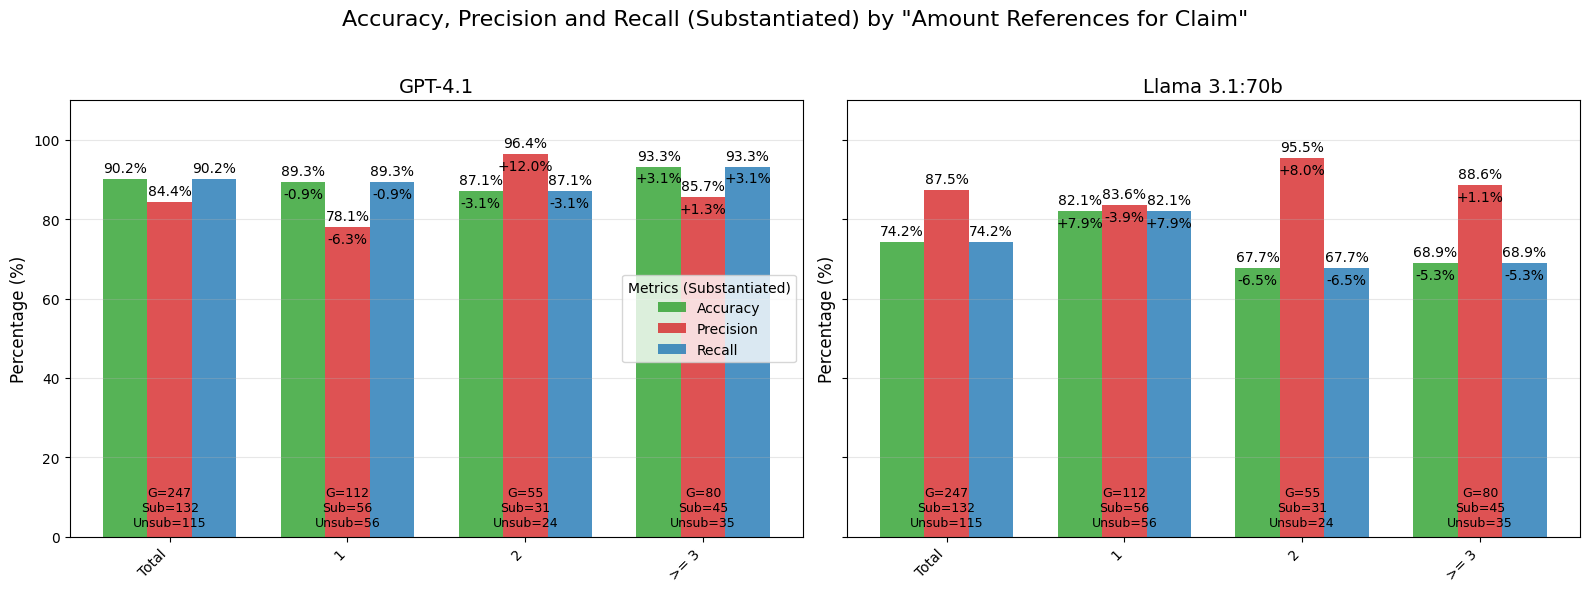

In [21]:
attribute = "Amount References for Claim"
results = attribute_predictions_per_model(model_dfs, attribute, group_numbers_from=3)
show_metrics_by_attribute_values(results, attribute, "Unsubstantiated")
show_metrics_by_attribute_values(results, attribute, "Substantiated")

In [22]:
significance_tests_per_model_for_attribute(model_dfs, attribute, group_numbers_from=3)

---- ## Significance tests results for GPT-4.1 on attribute 'Amount References for Claim': ## ----
Fisher's exact test results (per attributevalue when compared to rest):


,Total Odds Ratio,Total P-value,Unsubstantiated Odds Ratio,Unsubstantiated P-value,Substantiated Odds Ratio,Substantiated P-value
Attribute Value,,,,,,
1,0.5750,0.1453,0.4706,0.1558,0.8454,0.7764
2,1.8519,0.2763,6.9000,0.0412,0.6603,0.5025
>= 3,1.2324,0.6987,0.9231,1.0000,1.8182,0.5412


Chi-squared test results (comparison over all attribute values):


,Total Chi2,Total P-value,Unsubstantiated Chi2,Unsubstantiated P-value,Substantiated Chi2,Substantiated P-value
0,0.8649,0.6489,3.4225,0.1806,1.2437,0.5369


Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,-0.000594,0.6250,N/A,N/A,N/A,N/A
Accuracy,-0.000620,0.6620,0.002542,0.1530,-0.000433,0.5250
Precision,N/A,N/A,-0.001483,0.7160,0.001719,0.1620
Recall,N/A,N/A,0.002542,0.1530,-0.000433,0.5250
F1 Score,N/A,N/A,-0.001005,0.6840,-0.000569,0.6570





---- ## Significance tests results for Llama 3.1:70b on attribute 'Amount References for Claim': ## ----
Fisher's exact test results (per attributevalue when compared to rest):


,Total Odds Ratio,Total P-value,Unsubstantiated Odds Ratio,Unsubstantiated P-value,Substantiated Odds Ratio,Substantiated P-value
Attribute Value,,,,,,
1,1.3391,0.4211,0.4835,0.2608,2.1231,0.1065
2,0.9548,1.0000,3.8333,0.2944,0.6545,0.3553
>= 3,0.7543,0.3962,1.1071,1.0000,0.6610,0.4012


Chi-squared test results (comparison over all attribute values):


,Total Chi2,Total P-value,Unsubstantiated Chi2,Unsubstantiated P-value,Substantiated Chi2,Substantiated P-value
0,1.6954,0.4284,3.3099,0.1911,4.7903,0.0912


Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,-0.000776,0.6970,N/A,N/A,N/A,N/A
Accuracy,-0.000464,0.5150,0.000853,0.2140,0.003516,0.1380
Precision,N/A,N/A,0.002237,0.1760,0.000772,0.2600
Recall,N/A,N/A,0.000853,0.2140,0.003516,0.1380
F1 Score,N/A,N/A,-0.000718,0.5810,-0.000624,0.5260


### Claim Sentence Structure

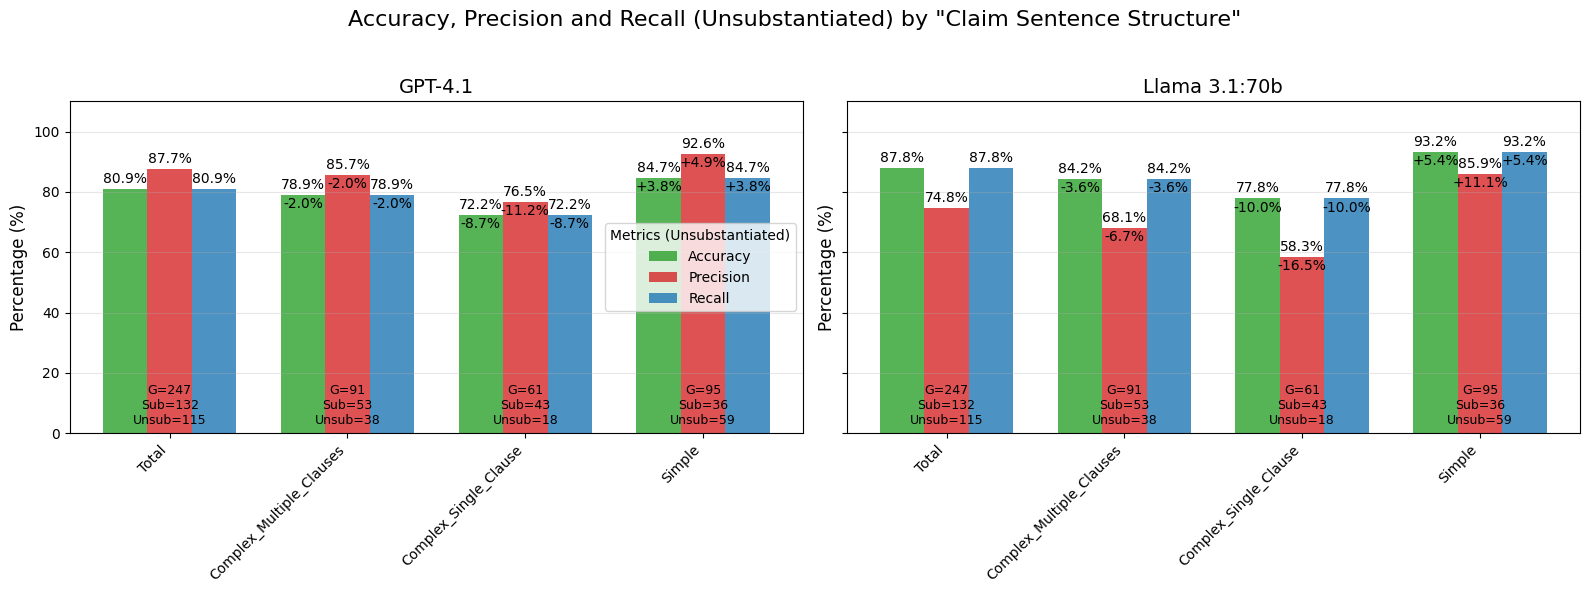

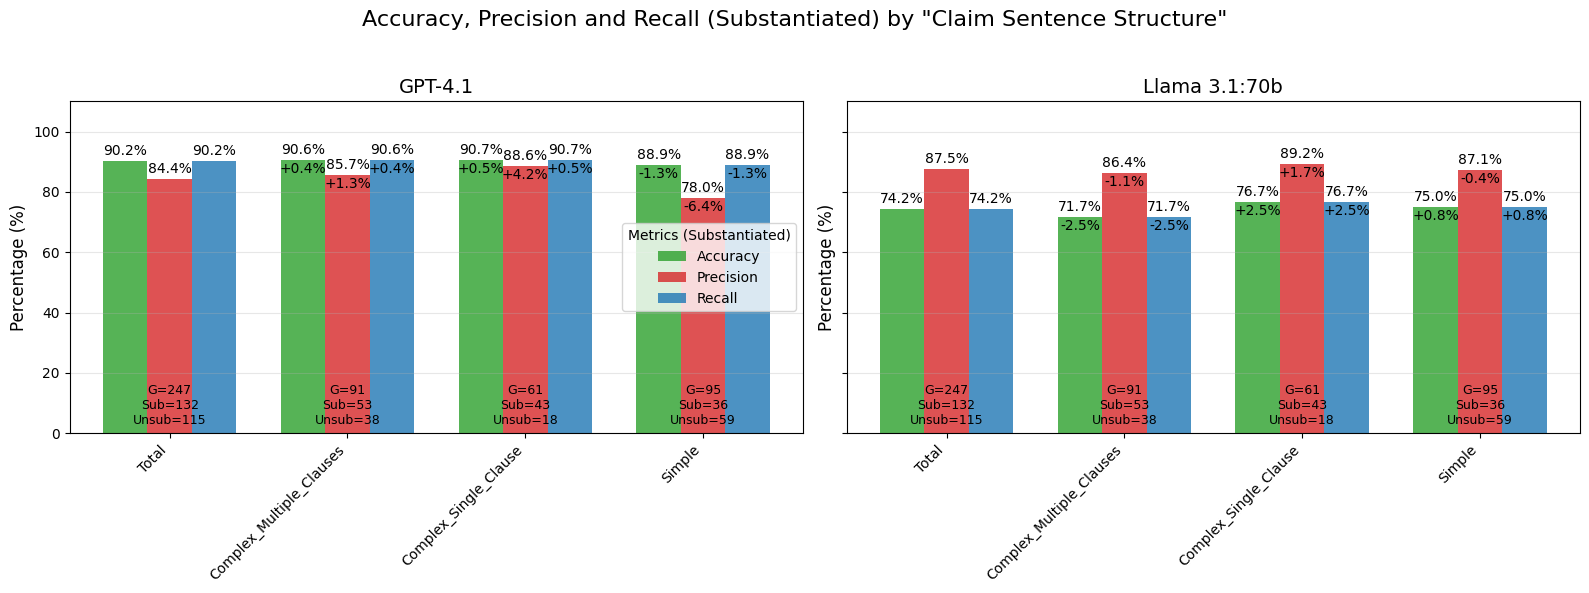

In [23]:
attribute = "Claim Sentence Structure"
results = attribute_predictions_per_model(model_dfs, attribute)
show_metrics_by_attribute_values(results, attribute, "Unsubstantiated")
show_metrics_by_attribute_values(results, attribute, "Substantiated")

In [24]:
significance_tests_per_model_for_attribute(model_dfs, attribute)

---- ## Significance tests results for GPT-4.1 on attribute 'Claim Sentence Structure': ## ----
Fisher's exact test results (per attributevalue when compared to rest):


,Total Odds Ratio,Total P-value,Unsubstantiated Odds Ratio,Unsubstantiated P-value,Substantiated Odds Ratio,Substantiated P-value
Attribute Value,,,,,,
Simple,1.0675,1.0000,1.6796,0.3453,0.8276,0.7500
Complex_Multiple_Clauses,0.9851,1.0000,0.8333,0.8021,1.0817,1.0000
Complex_Single_Clause,0.9389,0.8356,0.5525,0.3331,1.0969,1.0000


Chi-squared test results (comparison over all attribute values):


,Total Chi2,Total P-value,Unsubstantiated Chi2,Unsubstantiated P-value,Substantiated Chi2,Substantiated P-value
0,0.5858,0.7461,0.2808,0.8690,0.1593,0.9234


Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,-0.000953,0.8800,N/A,N/A,N/A,N/A
Accuracy,-0.000682,0.6980,-0.002612,0.8870,-0.001267,0.9440
Precision,N/A,N/A,0.002864,0.0900,0.003592,0.0620
Recall,N/A,N/A,-0.002612,0.8870,-0.001267,0.9440
F1 Score,N/A,N/A,-0.000038,0.3570,0.000910,0.1320





---- ## Significance tests results for Llama 3.1:70b on attribute 'Claim Sentence Structure': ## ----
Fisher's exact test results (per attributevalue when compared to rest):


,Total Odds Ratio,Total P-value,Unsubstantiated Odds Ratio,Unsubstantiated P-value,Substantiated Odds Ratio,Substantiated P-value
Attribute Value,,,,,,
Simple,1.8869,0.0976,2.9891,0.0895,1.0563,1.0000
Complex_Multiple_Clauses,0.6977,0.3176,0.6184,0.5450,0.8022,0.6854
Complex_Single_Clause,0.7509,0.4572,0.4023,0.2299,1.2185,0.8321


Chi-squared test results (comparison over all attribute values):


,Total Chi2,Total P-value,Unsubstantiated Chi2,Unsubstantiated P-value,Substantiated Chi2,Substantiated P-value
0,2.3125,0.3147,1.6986,0.4277,0.6067,0.7384


Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,0.000128,0.3230,N/A,N/A,N/A,N/A
Accuracy,-0.000141,0.3830,0.000713,0.2360,-0.002569,0.7930
Precision,N/A,N/A,0.012453,0.0090,0.001854,0.1090
Recall,N/A,N/A,0.000713,0.2360,-0.002569,0.7930
F1 Score,N/A,N/A,0.003974,0.0340,-0.000451,0.4640


### Amount Claims to Substantiate

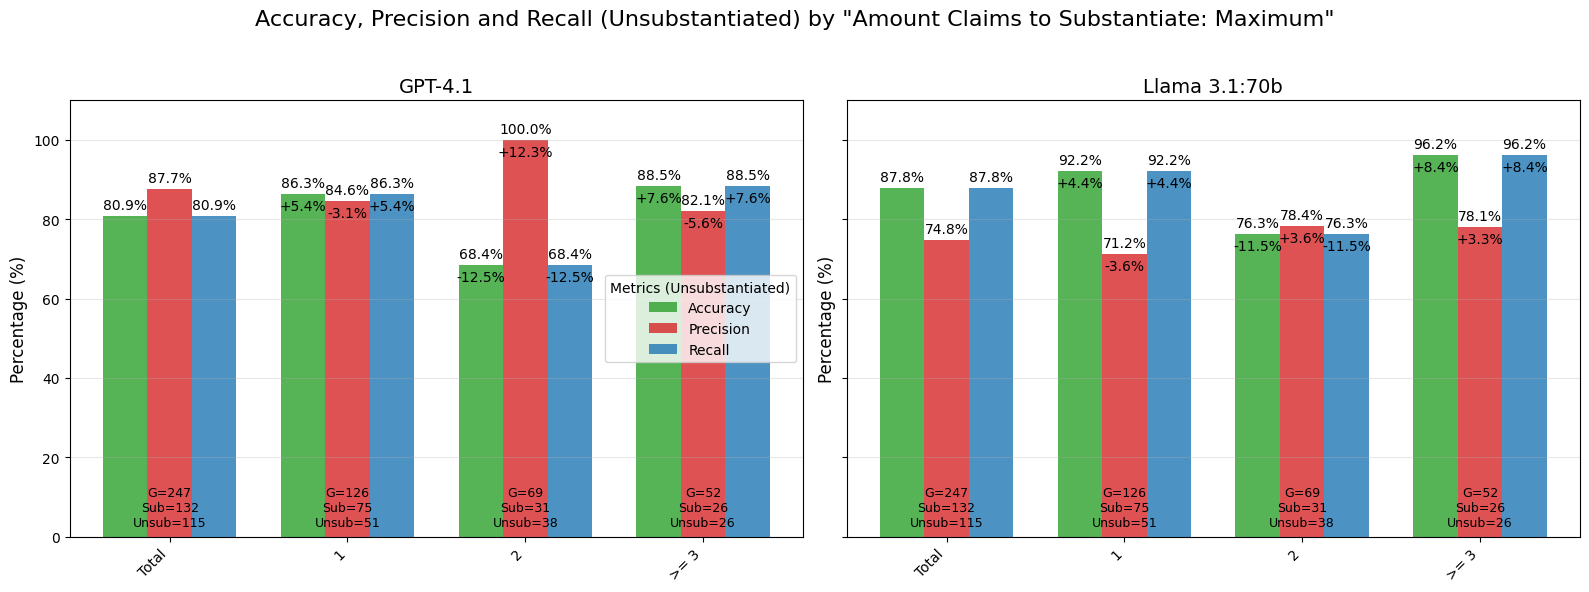

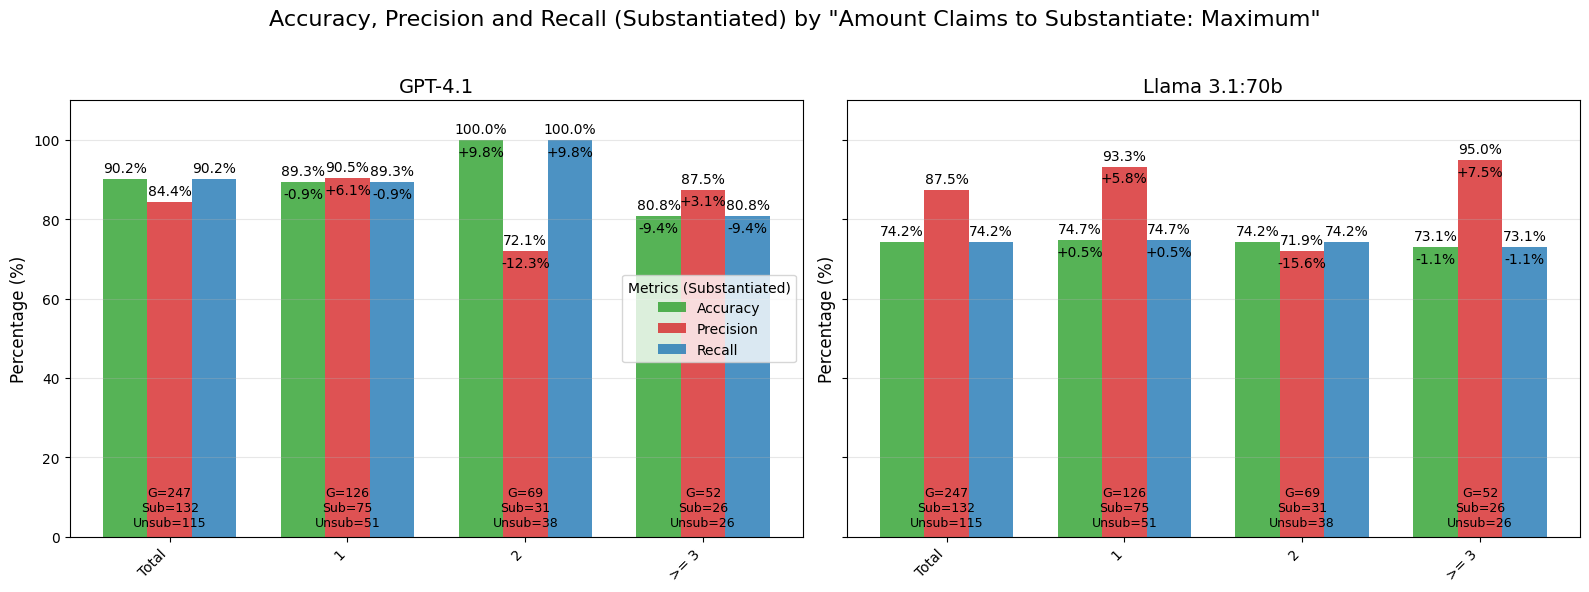

In [25]:
attribute = "Amount Claims to Substantiate: Maximum"
results = attribute_predictions_per_model(model_dfs, attribute, group_numbers_from=3)
show_metrics_by_attribute_values(results, attribute, "Unsubstantiated")
show_metrics_by_attribute_values(results, attribute, "Substantiated")

In [26]:
significance_tests_per_model_for_attribute(model_dfs, attribute, group_numbers_from=3)

---- ## Significance tests results for GPT-4.1 on attribute 'Amount Claims to Substantiate: Maximum': ## ----
Fisher's exact test results (per attributevalue when compared to rest):


,Total Odds Ratio,Total P-value,Unsubstantiated Odds Ratio,Unsubstantiated P-value,Substantiated Odds Ratio,Substantiated P-value
Attribute Value,,,,,,
1,1.4653,0.3623,1.9242,0.2361,0.8053,0.7764
2,0.7048,0.4166,0.3234,0.0235,N/A,N/A
>= 3,0.8839,0.8233,2.0810,0.3963,0.3429,0.1324


Chi-squared test results (comparison over all attribute values):


,Total Chi2,Total P-value,Unsubstantiated Chi2,Unsubstantiated P-value,Substantiated Chi2,Substantiated P-value
0,2.0015,0.3676,5.1529,0.0760,6.4697,0.0394


Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,-0.000540,0.5710,N/A,N/A,N/A,N/A
Accuracy,-0.000316,0.4580,0.003439,0.1210,0.004617,0.0220
Precision,N/A,N/A,0.003556,0.0810,0.003341,0.0790
Recall,N/A,N/A,0.003439,0.1210,0.004617,0.0220
F1 Score,N/A,N/A,-0.001192,0.7530,0.000124,0.3010





---- ## Significance tests results for Llama 3.1:70b on attribute 'Amount Claims to Substantiate: Maximum': ## ----
Fisher's exact test results (per attributevalue when compared to rest):


,Total Odds Ratio,Total P-value,Unsubstantiated Odds Ratio,Unsubstantiated P-value,Substantiated Odds Ratio,Substantiated P-value
Attribute Value,,,,,,
1,1.1662,0.7480,2.1759,0.2582,1.0526,1.0000
2,0.6451,0.2123,0.2238,0.0135,0.9967,1.0000
>= 3,1.4194,0.5540,4.2763,0.1855,0.9277,1.0000


Chi-squared test results (comparison over all attribute values):


,Total Chi2,Total P-value,Unsubstantiated Chi2,Unsubstantiated P-value,Substantiated Chi2,Substantiated P-value
0,1.3691,0.5043,7.4526,0.0241,0.1031,0.9498


Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,0.000147,0.3250,N/A,N/A,N/A,N/A
Accuracy,-0.000343,0.4540,0.003700,0.0250,-0.003321,0.9660
Precision,N/A,N/A,-0.002378,0.7900,0.006930,0.0160
Recall,N/A,N/A,0.003700,0.0250,-0.003321,0.9660
F1 Score,N/A,N/A,-0.000660,0.5300,-0.000115,0.3850


The accuracy is slightly higher when there is only one claim in the sentence related to this citation, and slightly lower when there 2-4 claims (Llama 3.1). For more than 4 claims there are only less than 10 examples in the dataset, so the results are not really reliable. For GPT 4.1 the accuracy increases for a maximum of 4 claims for some reason?